# Introduction

The temperature measurement is done with the following circuit:

![](schematic-sensor.png)

see also [Circuit Simulation](http://falstad.com/circuit/circuitjs.html?ctz=CQAgjCAMB0l3BWcMBMcUHYMGZIA4UA2ATmIxEIiQBZsAoANxGMJG0L2dZal+shAJY2XgJgI6AJy4yUCbqwFhIhFFJByFG+Ww68U1fus0z+AnkrzxI6s6bgaD+tPFsOUTu+05LrNgO4y3tqswQEhupxeejYADiB2HtSCYCiOyRBidPF2PNQ8PJlQ2REFoXpFNkA)

The value of the thermistor is defined as $ R_T=R_N \cdot e^{B \cdot \left(\frac{1}{T} - \frac{1}{T_N}\right)} $ with $ T_N = 298.15 $. 

This results in: $ T = \frac{B \cdot T_N}{B + \ln\left( \frac{R_T}{R_N} \right) \cdot T_N} $

*Please note: Temperature values must be given in Kelvin.*

In [1]:
from IPython.display import Markdown as md
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [16,8]

In [2]:
pt1000 = np.array([[-20, -15, -10, -5, 0,5,10,15,20,25,30],[8194, 6256, 4825, 3758, 2954, 2342,1872,1508,1224,1000,823]])
R_N = 1000
T_N = 298.15

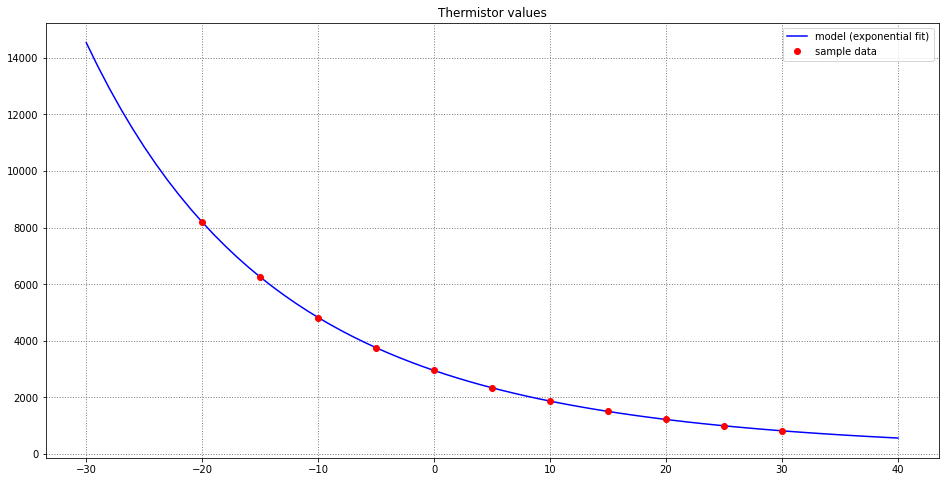

In [3]:
def func(T, B):
    return R_N * np.exp(B*(1/T - 1/T_N)) 

popt, pcov = curve_fit(func, pt1000[0]+273.15, pt1000[1])
B=popt[0]
x_data = np.arange(-30, 41, 1)
y_data = func(x_data+273.15, *popt)

plt.plot(x_data, y_data, 'b-', label='model (exponential fit)')

stdevs = np.sqrt(np.diag(pcov))

plt.plot(pt1000[0], pt1000[1], 'ro', label='sample data')
plt.legend()
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Thermistor values');

In [4]:
md("Based on model data we get $B={:.3f} \pm {:.2f}$.".format(B, stdevs[0]))

Based on model data we get $B=3528.009 \pm 0.04$.

## Calculating the temperature

To actually calculate the current temperature from a given ADC-value we need to

1. get a general idea what the formula looks like
2. sample data

In [15]:
raw = np.array([787, 780, 773, 754, 749, 729, 717, 722, 725, 731.3, 746.6, 754.9, 763.7, 748.7, 742.5, 715.6, 699.5, 694, 677, 688, 672, 659, 644.7, 666.5, 655.7, 609.5, 626, 745, 809, 810.3, 761.4, 765.5, 777.1, 786.45, 793, 794.4, 796.6, 799.4, 822.1, 823.8, 824.2, 801.1, 716.7, 710.7, 706.7])
temp = np.array([28.1, 27, 26.7, 24.4, 24, 21.5, 20.3, 20.7, 21, 21.6, 23.5, 24.4, 25.5, 23.7, 23, 20.1, 18.6, 18.3, 16.5, 17.5, 15.9, 14.6, 13.3, 15.5, 14.3, 10.1, 11.5, 23.1, 31.3, 31.5, 25.2, 25.8, 27.3, 28.5, 29, 29.4, 29.8, 30.1, 33.2, 33.5, 33.5, 30.2, 20.3, 19.5, 19.1])+273.15

### Linear approach

$ T = m \cdot \mathit{raw} + b $

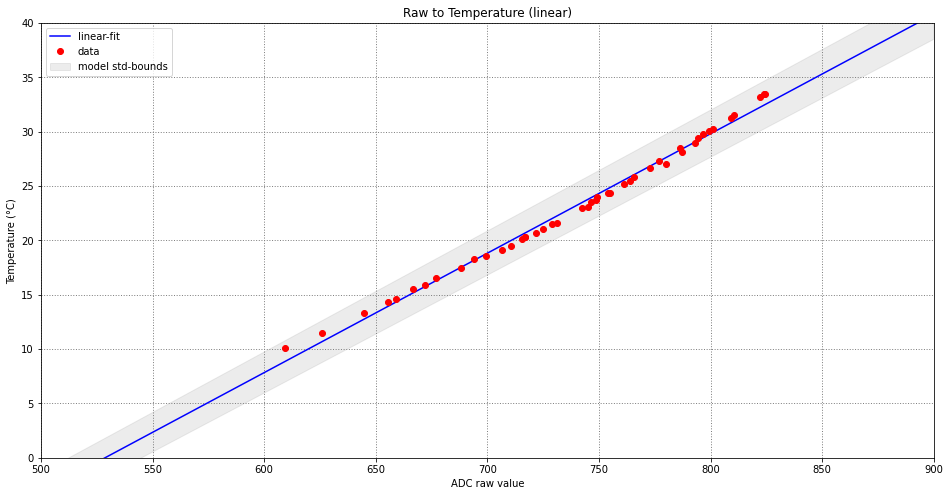

In [16]:
# linear approach
def func(x, m, b):
    return m * x + b

popt, pcov = curve_fit(func, raw, temp)
a=popt[0]
b=popt[1]

x_data = np.arange(500, 901, 10)
y_data = func(x_data, *popt)

plt.rcParams['figure.figsize'] = [16,8]

plt.plot(x_data, y_data-273.15, 'b-', label='linear-fit')

stdevs = np.sqrt(np.diag(pcov))

upper = func(x_data, popt[0]+stdevs[0], popt[1]+stdevs[1])-273.15
lower = func(x_data, popt[0]-stdevs[0], popt[1]-stdevs[1])-273.15

plt.fill_between(x_data, upper, lower, color="grey", alpha=0.15, label='model std-bounds')

plt.plot(raw, temp-273.15, 'ro', label='data')
plt.rcParams['figure.figsize'] = [16,8]
plt.grid(color='grey', linestyle=':', linewidth=1)

plt.legend();
plt.axis([500, 900, 0, 40]);
plt.title('Raw to Temperature (linear)');
plt.xlabel('ADC raw value');
plt.ylabel('Temperature (°C)');

In [17]:
md("Based on linear model we get $m={:.3f} \pm {:.3f}$ and $b={:.3f} \pm {:.3f}$.".format(a, stdevs[0], b, stdevs[1]))

Based on linear model we get $m=0.110 \pm 0.001$ and $b=215.065 \pm 1.043$.

In [18]:
a, b

(0.10986582016275614, 215.06451749131375)

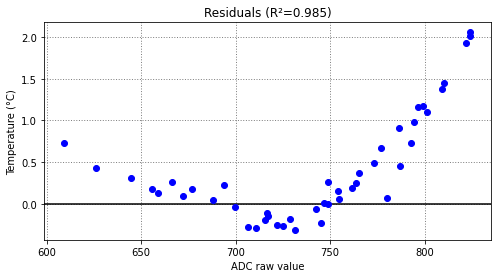

In [19]:
def func(x, m, b):
    return m * x + b

x_data = raw
residuals = temp-func(x_data, 0.103, 219.74);

ss_res = np.sum(residuals**2)
ss_tot = np.sum((temp-np.mean(temp))**2)
r_squared = 1 - (ss_res / ss_tot)

plt.rcParams['figure.figsize'] = [8,4]
plt.axhline( color='black');
plt.plot(x_data, residuals, 'bo', label='residuals');
plt.grid(color='grey', linestyle=':', linewidth=1)

plt.title('Residuals (R²={:.3})'.format(r_squared));
plt.xlabel('ADC raw value');
plt.ylabel('Temperature (°C)');

In [20]:
np.sum(residuals**3)

37.43926215716609


### Logarithmic approach

Based on 

$$ T = \frac{B \cdot T_N}{B + \ln\left( \frac{R_T}{R_N} \right) \cdot T_N} $$

$$ U_2 = V_{CC} \cdot R_2 \cdot \frac{R_4}{(R_1+R_2+R_3) \cdot R_4 + R_T \cdot \left(R_1+ R_2+ R_3 + R_4 \right)} $$

transforms to
$$
\begin{align}
 \frac{U_2}{V_{CC} \cdot R_2 \cdot R_4} &= \frac{1}{(R_1+R_2+R_3) \cdot R_4 + R_T \cdot (R_1+R_2+R_3+R_4)} \\
 \frac{V_{CC} \cdot R_2 \cdot R_4}{U_2} &= (R_1+R_2+R_3) \cdot R_4 + R_T \cdot (R_1+R_2+R_3+R_4) \\
 \frac{V_{CC} \cdot R_2 \cdot R_4}{U_2} - (R_1+R_2+R_3) \cdot R_4 &=  R_T \cdot (R_1+R_2+R_3+R_4) \\
 R_T &= \frac{V_{CC} \cdot R_2 \cdot R_4}{U_2 \cdot (R_1+R_2+R_3+R_4)} - \frac{R_4 \cdot (R_1+R_2+R_3)}{(R_1+R_2+R_3+R_4)} \\
 R_T &= \frac{R_4}{(R_1+R_2+R_3+R_4)} \cdot \left(\frac{V_{CC} \cdot R_2}{U_2} - (R_1+R_2+R_3) \right)
\end{align} 
 $$

Model:
$$ 
\begin{align}
R_{T_{Model}}(U_2, a, b) &= \frac{a}{U_2} + b \\
T_{Model}(U_2, a, b) &= \frac{B \cdot T_N}{B + \ln\left( \frac{\frac{a}{U_2}+b}{R_N} \right) \cdot T_N}
\end{align}
$$

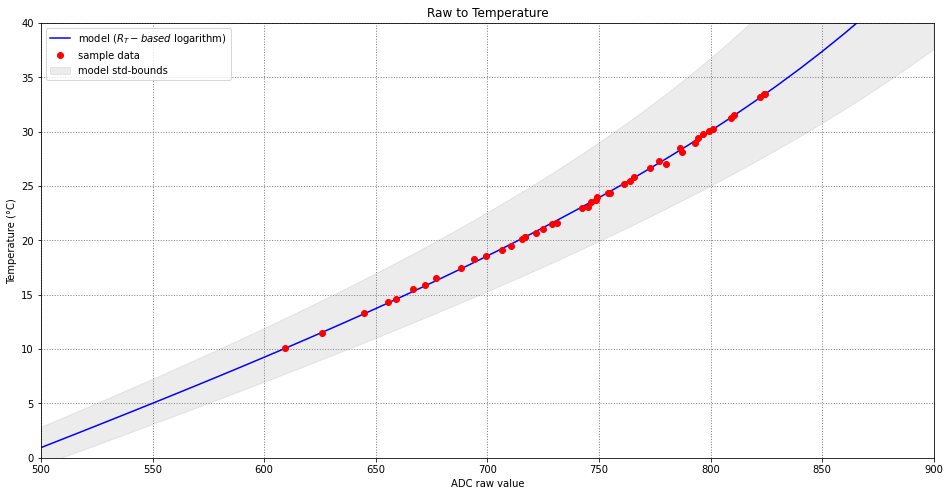

In [21]:
# logarithmic approach
def func(x, a, b):
    RT = a/x+b
    return B * T_N / (B + np.log(RT/R_N)*T_N)

popt, pcov = curve_fit(func, raw, temp, absolute_sigma=True)
a=popt[0]
b=popt[1]

x_data = np.arange(500, 901, 10)
y_data = func(x_data, *popt);

plt.rcParams['figure.figsize'] = [16,8]
plt.plot(x_data, y_data-273.15, 'b-', label='model ($R_T-based$ logarithm)');

stdevs = np.sqrt(np.diag(pcov))

upper = func(x_data, popt[0]+stdevs[0], popt[1]+stdevs[1])-273.15
lower = func(x_data, popt[0]-stdevs[0], popt[1]-stdevs[1])-273.15

plt.fill_between(x_data, upper, lower, color="grey", alpha=0.15, label='model std-bounds')

plt.plot(raw, temp-273.15, 'ro', label='sample data');
plt.rcParams['figure.figsize'] = [16,8]
plt.grid(color='grey', linestyle=':', linewidth=1)

plt.legend();
plt.axis([500, 900, 0, 40]);
plt.title('Raw to Temperature');
plt.xlabel('ADC raw value');
plt.ylabel('Temperature (°C)');

In [22]:
md("Based on logarithmic model, we get $a={:.3f} \pm {:.3f}$% and $b={:.3f} \pm {:.3f}$%.".format(popt[0], abs(stdevs[0]/popt[0]*100), popt[1], abs(stdevs[1]/popt[1]*100)))

Based on logarithmic model, we get $a=2673864.840 \pm 2.641$% and $b=-2521.618 \pm 3.674$%.

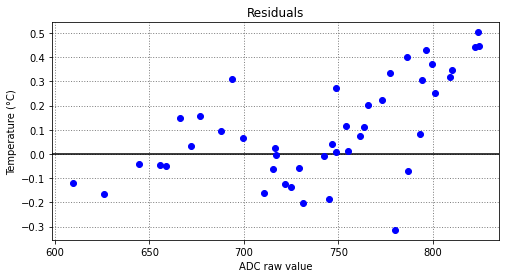

In [13]:
def func(x, a, b):
    RT = a/x+b
    return B * T_N / (B + np.log(RT/R_N)*T_N)

x_data = raw
residuals = temp-func(x_data, 2622921.367, -2449.817);

plt.rcParams['figure.figsize'] = [8,4]
plt.axhline( color='black');
plt.plot(x_data, residuals, 'bo', label='residuals');
plt.grid(color='grey', linestyle=':', linewidth=1)

plt.title('Residuals');
plt.xlabel('ADC raw value');
plt.ylabel('Temperature (°C)');

In [14]:
np.sum(residuals**3)

0.6711552581826078